In [96]:
import sys
sys.path.append("../")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy import distance
import plotly.express as px
import numpy as np
import swifter
import re
from src.utils.text_cleaner import remove_stopwords_punctuaction, replace_number_words_with_ordinals
from src.utils.etl import extract, transform, load_data


pd.set_option('display.max_columns', 500)
sns.set(style="whitegrid", palette="pastel", color_codes=True) 

In [97]:
if False:
    df = pd.read_parquet('../data/raw/properati_a_predecir.parquet', engine='pyarrow')
    df = transform(df, 16)
    df.to_parquet('../data/processed/properati_a_predecir.parquet', engine='pyarrow')
else:
    df= pd.read_parquet('../data/processed/properati_a_predecir.parquet', engine='pyarrow')

In [98]:
df.head(2)

,ad_type,start_date,end_date,created_on,lat,lon,country,province,city_neighorhood,published_neigborhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
id,,,,,,,,,,,,,,,,,,,,,,
464741,Propiedad,2019-07-04,2019-07-09,2019-07-04,-34.595365,-58.445631,Argentina,Capital Federal,Villa Crespo,None,3.0,2.0,1.0,68.0,63.0,NaN,USD,None,departamento 3 ambientes venta villa crespo,excelente departamento 3 ambientes refaccionad...,Departamento,Venta
464202,Propiedad,2019-07-04,2019-07-09,2019-07-04,-34.599384,-58.411898,Argentina,Capital Federal,Barrio Norte,None,2.0,1.0,1.0,52.0,42.0,NaN,USD,None,san luis 3200,san luis agüero 2 ambientes balcón corrido fre...,Departamento,Venta


In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6000 entries, 464741 to 144328
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ad_type                6000 non-null   object        
 1   start_date             6000 non-null   datetime64[ns]
 2   end_date               4812 non-null   datetime64[ns]
 3   created_on             6000 non-null   datetime64[ns]
 4   lat                    5545 non-null   float64       
 5   lon                    5544 non-null   float64       
 6   country                6000 non-null   object        
 7   province               6000 non-null   object        
 8   city_neighorhood       5789 non-null   object        
 9   published_neigborhood  459 non-null    object        
 10  rooms                  6000 non-null   float64       
 11  bedrooms               4935 non-null   float64       
 12  bathrooms              5782 non-null   float64       
 13  s

In [100]:
df.isna().sum() / len(df)

ad_type                  0.000000
start_date               0.000000
end_date                 0.198000
created_on               0.000000
lat                      0.075833
lon                      0.076000
country                  0.000000
province                 0.000000
city_neighorhood         0.035167
published_neigborhood    0.923500
rooms                    0.000000
bedrooms                 0.177500
bathrooms                0.036333
surface_total            0.204000
surface_covered          0.186833
price                    1.000000
currency                 0.000000
price_period             0.680833
title                    0.000000
description              0.000000
property_type            0.000000
operation_type           0.000000
dtype: float64

In [101]:
df = df.drop(["price"], axis=1)

In [102]:
cat_cols = 'ad_type currency price_period property_type operation_type country province'.split()
num_cols = 'surface_total surface_covered bathrooms bedrooms'.split()

In [103]:
# potential usful cols: price_usd_per_m2 price_per_m2

## Graph Viz

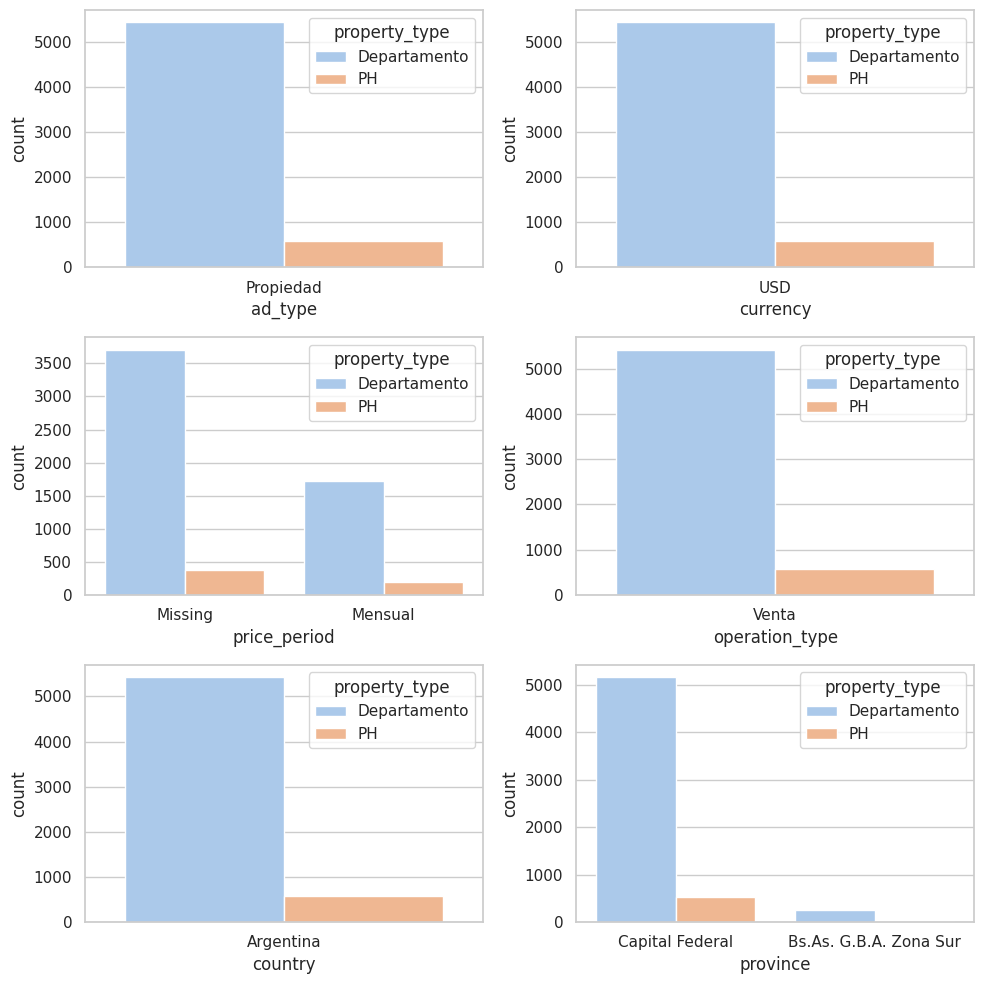

In [104]:
fig, axes = plt.subplots(3,2, figsize=(10,10))

axes = axes.flat

hue='property_type'
cat_cols_temp = cat_cols.copy()
cat_cols_temp.remove(hue)

for i,col in enumerate(cat_cols_temp):
    sns.countplot(x=col, data=df.fillna("Missing"), ax=axes[i], hue=hue)
plt.tight_layout()
plt.show()

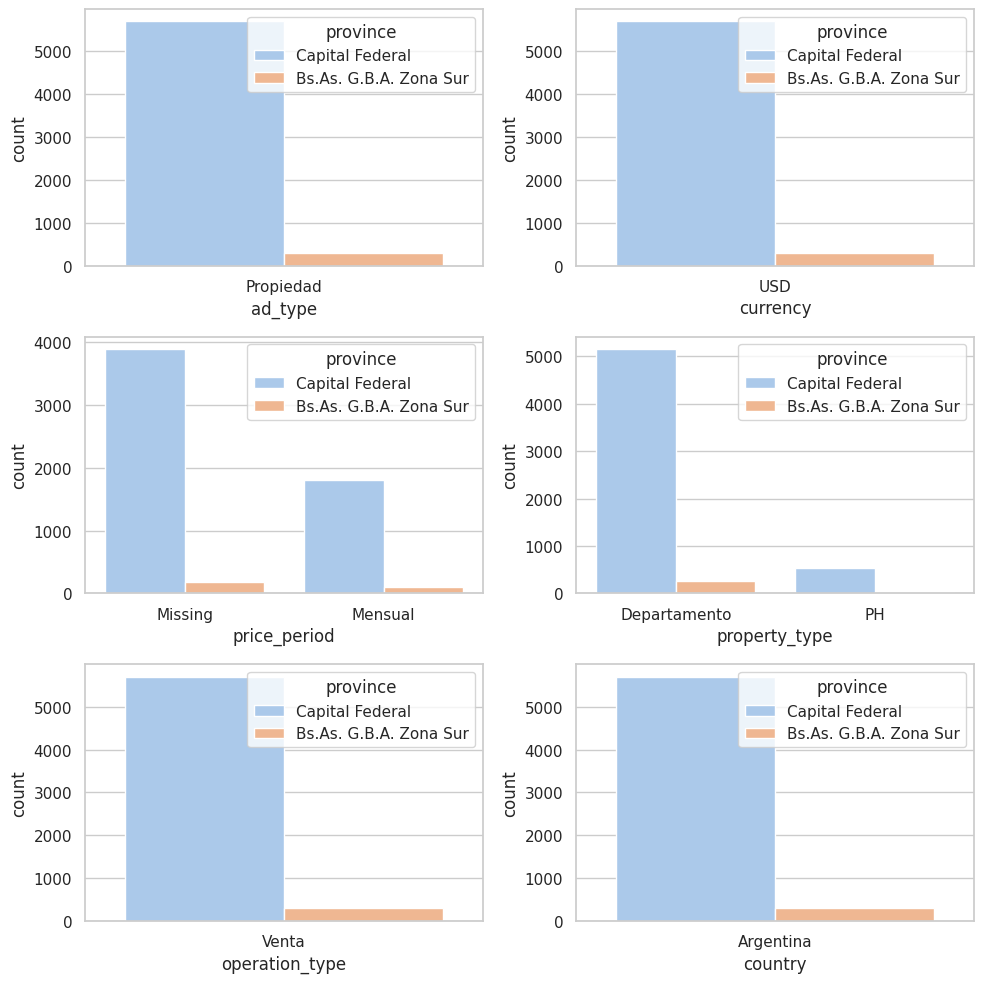

In [105]:
fig, axes = plt.subplots(3,2, figsize=(10,10))

axes = axes.flat

hue='province'
cat_cols_temp = cat_cols.copy()
cat_cols_temp.remove(hue)

for i,col in enumerate(cat_cols_temp):
    sns.countplot(x=col, data=df.fillna("Missing"), ax=axes[i], hue=hue)
plt.tight_layout()
plt.show()

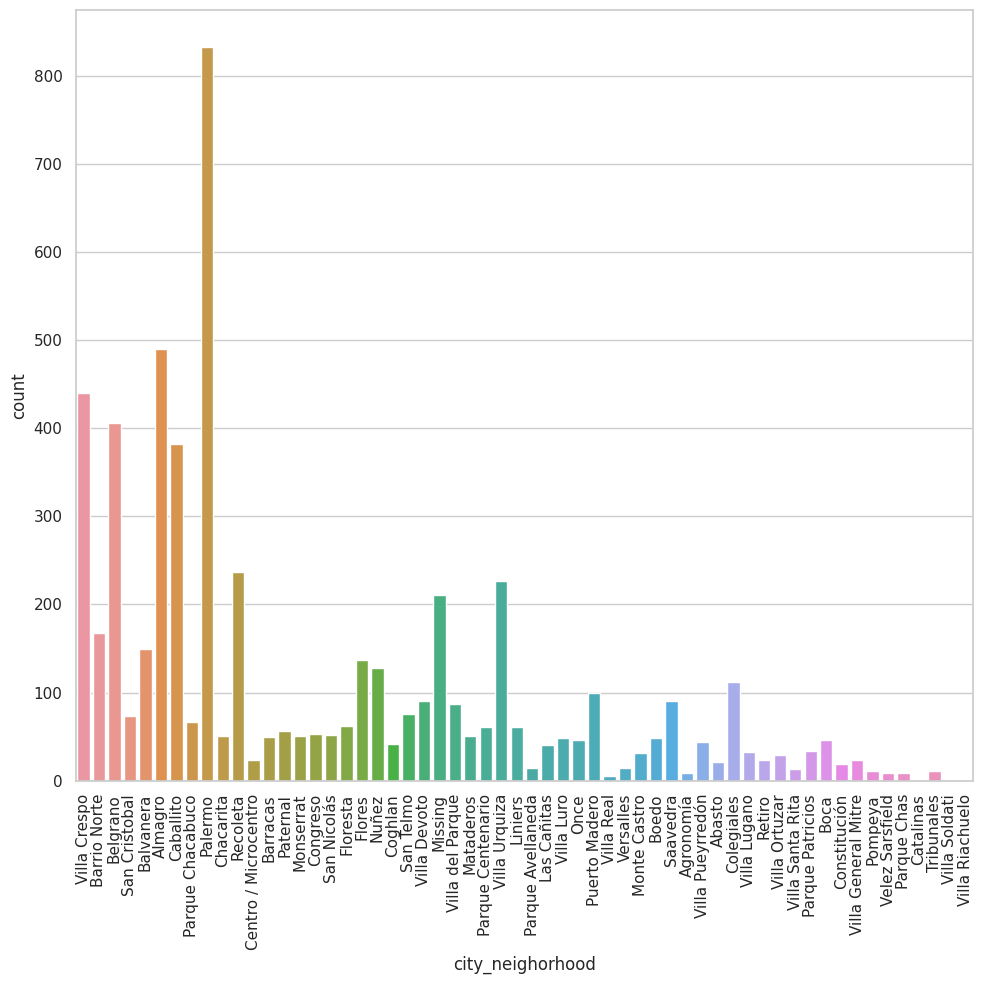

In [106]:
plt.figure(figsize=(10,10))
sns.countplot(x='city_neighorhood', data=df[df["province"]==  "Capital Federal"].fillna("Missing"))

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

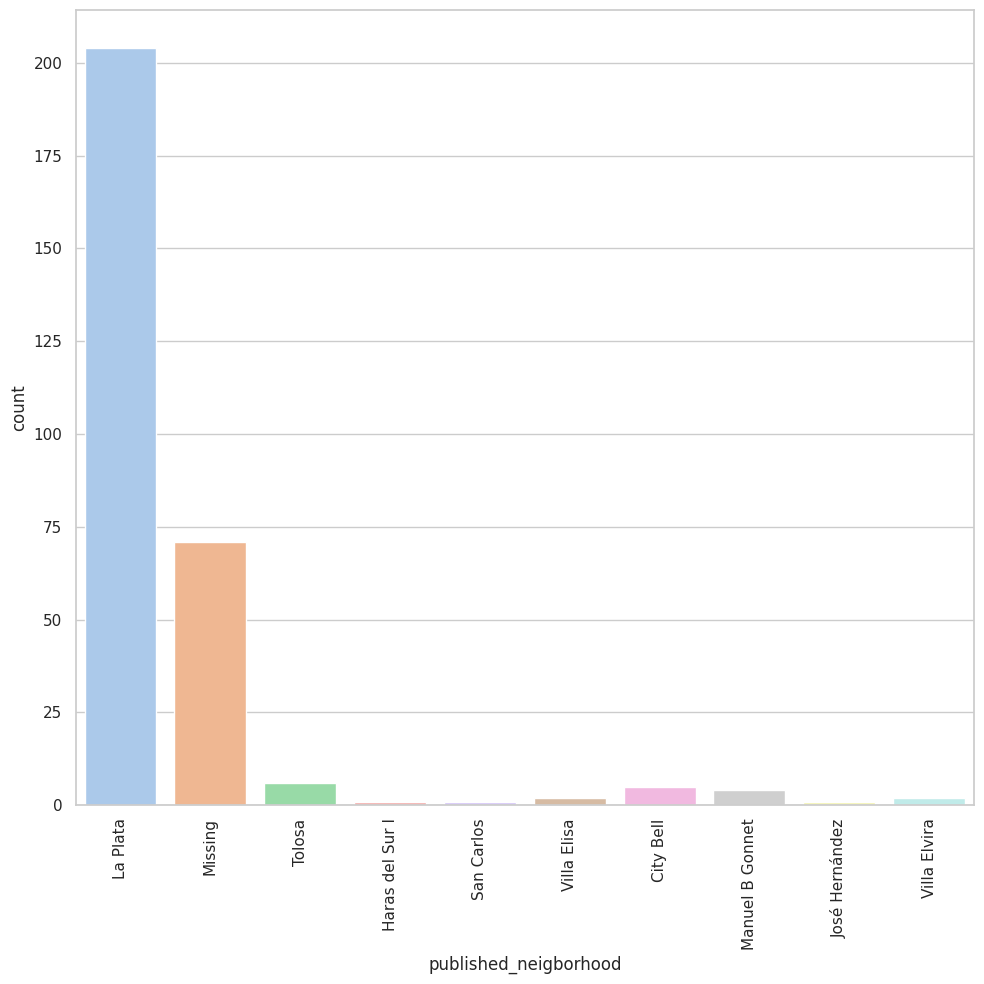

In [107]:
plt.figure(figsize=(10,10))
sns.countplot(x='published_neigborhood', data=df[df["province"]=="Bs.As. G.B.A. Zona Sur"].fillna("Missing"))

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

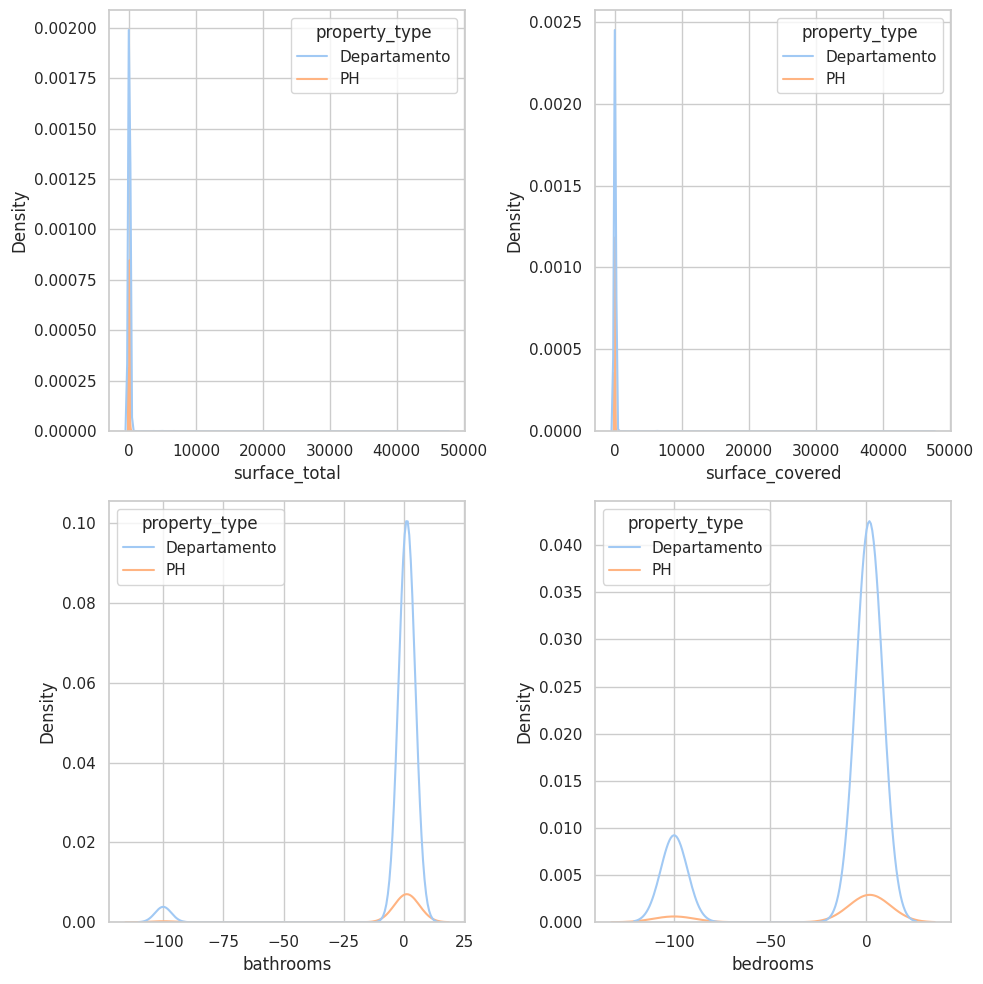

In [108]:
fig, axes = plt.subplots(2,2, figsize=(10,10))

axes = axes.flat

hue='property_type'
cat_cols_temp = cat_cols.copy()
cat_cols_temp.remove(hue)

for i,col in enumerate(num_cols):
    sns.kdeplot(x=col, data=df.fillna(-100), ax=axes[i], hue=hue)

plt.tight_layout()
plt.show()

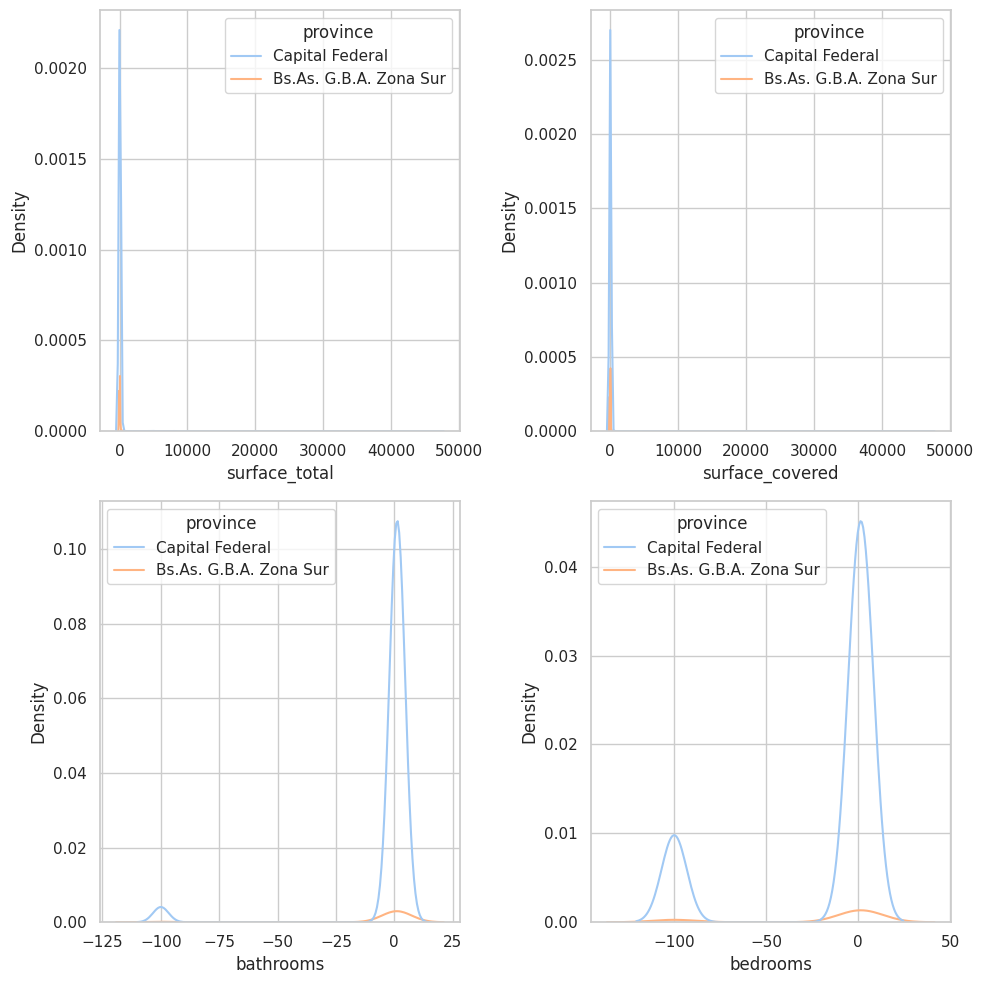

In [109]:
fig, axes = plt.subplots(2,2, figsize=(10,10))

axes = axes.flat

hue='province'
cat_cols_temp = cat_cols.copy()
cat_cols_temp.remove(hue)

for i,col in enumerate(num_cols):
    sns.kdeplot(x=col, data=df.fillna(-100), ax=axes[i], hue=hue)

plt.tight_layout()
plt.show()

In [110]:
df.describe(include='all')

,ad_type,start_date,end_date,created_on,lat,lon,country,province,city_neighorhood,published_neigborhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,currency,price_period,title,description,property_type,operation_type
count,6000,6000,4812,6000,5545.000000,5544.000000,6000,6000,5789,459,6000.000000,4935.000000,5782.000000,4776.000000,4879.000000,6000,1915,6000,6000,6000,6000
unique,1,NaN,NaN,NaN,NaN,NaN,1,2,58,13,NaN,NaN,NaN,NaN,NaN,1,1,3874,5094,2,1
top,Propiedad,NaN,NaN,NaN,NaN,NaN,Argentina,Capital Federal,Palermo,La Plata,NaN,NaN,NaN,NaN,NaN,USD,Mensual,departamento 2 ambientes venta villa crespo,hermoso 2 ambientes frente balcon aterrazado p...,Departamento,Venta
freq,6000,NaN,NaN,NaN,NaN,NaN,6000,5703,833,204,NaN,NaN,NaN,NaN,NaN,6000,1915,143,15,5426,6000
mean,NaN,2020-01-09 23:56:52.800000256,2020-02-25 00:21:14.812967680,2020-01-09 23:56:52.800000256,-34.598131,-58.445369,NaN,NaN,NaN,NaN,2.502667,1.509220,1.275683,91.936558,77.377126,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,2019-07-04 00:00:00,2019-07-06 00:00:00,2019-07-04 00:00:00,-40.156235,-71.345241,NaN,NaN,NaN,NaN,2.000000,0.000000,1.000000,10.000000,21.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,2019-10-12 00:00:00,2019-11-25 00:00:00,2019-10-12 00:00:00,-34.616927,-58.460256,NaN,NaN,NaN,NaN,2.000000,1.000000,1.000000,48.000000,43.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,2020-01-10 00:00:00,2020-02-20 00:00:00,2020-01-10 00:00:00,-34.600546,-58.433935,NaN,NaN,NaN,NaN,3.000000,2.000000,1.000000,60.000000,54.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,2020-04-14 00:00:00,2020-06-08 00:00:00,2020-04-14 00:00:00,-34.583789,-58.410085,NaN,NaN,NaN,NaN,3.000000,2.000000,1.000000,79.000000,68.000000,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,2020-07-27 00:00:00,2020-09-25 00:00:00,2020-07-27 00:00:00,-27.358836,-55.893583,NaN,NaN,NaN,NaN,3.000000,5.000000,6.000000,47360.000000,47360.000000,NaN,NaN,NaN,NaN,NaN,NaN


## Impute vals

In [111]:
df.isna().sum()

ad_type                     0
start_date                  0
end_date                 1188
created_on                  0
lat                       455
lon                       456
country                     0
province                    0
city_neighorhood          211
published_neigborhood    5541
rooms                       0
bedrooms                 1065
bathrooms                 218
surface_total            1224
surface_covered          1121
currency                    0
price_period             4085
title                       0
description                 0
property_type               0
operation_type              0
dtype: int64

In [112]:
df["lat"] = df["lat"].fillna(np.nan)
df["lon"] = df["lon"].fillna(np.nan)

In [113]:
df['value_is_NaN'] = df.apply(lambda x: (x.lat!=np.nan) & (x.lon == np.nan), axis=1)

In [114]:
lat, lon = df.iloc[0][["lat", "lon"]]

In [115]:
geolocator = Nominatim(user_agent="Bing")
location = geolocator.reverse((lat,lon))

print(location.raw)

{'place_id': 56355940, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'way', 'osm_id': 314918641, 'lat': '-34.595372059183674', 'lon': '-58.44563050000001', 'display_name': '1113, Camargo, Villa Crespo, Buenos Aires, Distrito Audiovisual, Comuna 15, Ciudad Autónoma de Buenos Aires, C1414CXQ, Argentina', 'address': {'house_number': '1113', 'road': 'Camargo', 'suburb': 'Villa Crespo', 'city': 'Buenos Aires', 'ISO3166-2-lvl8': 'AR-C', 'district': 'Distrito Audiovisual', 'state_district': 'Comuna 15', 'state': 'Ciudad Autónoma de Buenos Aires', 'ISO3166-2-lvl4': 'AR-C', 'postcode': 'C1414CXQ', 'country': 'Argentina', 'country_code': 'ar'}, 'boundingbox': ['-34.595422059184', '-34.595322059184', '-58.4456805', '-58.4455805']}


In [116]:
location = geolocator.geocode("Villa Elisa - Buenos Aires")
print(location.raw["lat"])
print(location.raw["lon"])

-34.8510614
-58.0873132


In [118]:
pd.options.display.max_rows = 999
df.head(2)

,ad_type,start_date,end_date,created_on,lat,lon,country,province,city_neighorhood,published_neigborhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,currency,price_period,title,description,property_type,operation_type,value_is_NaN
id,,,,,,,,,,,,,,,,,,,,,,
464741,Propiedad,2019-07-04,2019-07-09,2019-07-04,-34.595365,-58.445631,Argentina,Capital Federal,Villa Crespo,None,3.0,2.0,1.0,68.0,63.0,USD,None,departamento 3 ambientes venta villa crespo,excelente departamento 3 ambientes refaccionad...,Departamento,Venta,False
464202,Propiedad,2019-07-04,2019-07-09,2019-07-04,-34.599384,-58.411898,Argentina,Capital Federal,Barrio Norte,None,2.0,1.0,1.0,52.0,42.0,USD,None,san luis 3200,san luis agüero 2 ambientes balcón corrido fre...,Departamento,Venta,False


In [119]:
all_neigborhoods = []
for i in df["city_neighorhood"].dropna().unique():
    for j in i.split("/"):
        all_neigborhoods.append(j.strip().lower())

for i in df["published_neigborhood"].dropna().unique():
    for j in i.split("/"):
        all_neigborhoods.append(j.strip().lower())
        
all_neigborhoods = list(set(all_neigborhoods))

In [124]:
all_neigborhoods

['floresta',
 'villa elisa',
 'palermo viejo',
 'villa pueyrredón',
 'parque patricios',
 'villa general mitre',
 'villa devoto',
 'parque avellaneda',
 'villa elvira',
 'microcentro',
 'josé hernández',
 'villa luro',
 'velez sarsfield',
 'barrio norte',
 'san cristobal',
 'once',
 'agronomía',
 'palermo soho',
 'belgrano',
 'flores',
 'haras del sur i',
 'caballito',
 'villa ortuzar',
 'parque chas',
 'almagro',
 'manuel b gonnet',
 'colegiales',
 'monserrat',
 'puerto madero',
 'villa lugano',
 'palermo chico',
 'boedo',
 'monte castro',
 'balvanera',
 'versalles',
 'san telmo',
 'villa riachuelo',
 'catalinas',
 'las cañitas',
 'villa del parque',
 'mataderos',
 'barracas',
 'parque chacabuco',
 'congreso',
 'villa crespo',
 'la plata',
 'parque centenario',
 'constitución',
 'palermo hollywood',
 'villa soldati',
 'villa urquiza',
 'centro',
 'nuñez',
 'saavedra',
 'coghlan',
 'palermo',
 'liniers',
 'chacarita',
 'tolosa',
 'paternal',
 'pompeya',
 'san carlos',
 'villa real',
 '

In [139]:
df_barrios = pd.read_csv("../data/external/barrios/barrios_caba.csv")

In [144]:
for i in df_barrios["BARRIO"].unique():
    if i.lower() not in all_neigborhoods:
        all_neigborhoods.append(i.strip().lower())

In [129]:
df[df["city_neighorhood"].isna()].iloc[10]["description"]

'departamento venta 3 ambientes frente cocina living comedor integrado balcon salida living 2 dormitorios bano completotiene 59,30 metros cuadrados cubiertos 8,65 metros cuadrados semidescubiertos 14,05 metros descubiertos.este departamento luminoso ambientes encuentran ventilados entrega totalmente equipado.se barrio villa luro metros plaza andes rodeado comercios edificio actualmente construccion obra finaliza diciembre 2022 amplias posibilidades financiacion.hay cocheras disponibles publicado traves visualgestion'

In [146]:
imputer = df["title"].apply(lambda x: x if x in all_neigborhoods else np.nan)

df["city_neighorhood"] = df["city_neighorhood"].fillna(imputer)

imputer = df["description"].apply(lambda x: x if x in all_neigborhoods else np.nan)
df["city_neighorhood"] = df["city_neighorhood"].fillna(imputer)

In [148]:
df.isna().sum()

ad_type                     0
start_date                  0
end_date                 1188
created_on                  0
lat                       455
lon                       456
country                     0
province                    0
city_neighorhood          211
published_neigborhood    5541
rooms                       0
bedrooms                 1065
bathrooms                 218
surface_total            1224
surface_covered          1121
currency                    0
price_period             4085
title                       0
description                 0
property_type               0
operation_type              0
value_is_NaN                0
dtype: int64

In [149]:
location = geolocator.reverse(str(lat) + "," + str(lon))
location.raw["address"]

{'house_number': '1113',
 'road': 'Camargo',
 'suburb': 'Villa Crespo',
 'city': 'Buenos Aires',
 'ISO3166-2-lvl8': 'AR-C',
 'district': 'Distrito Audiovisual',
 'state_district': 'Comuna 15',
 'state': 'Ciudad Autónoma de Buenos Aires',
 'ISO3166-2-lvl4': 'AR-C',
 'postcode': 'C1414CXQ',
 'country': 'Argentina',
 'country_code': 'ar'}

In [150]:
df[df["province"].isin(["Bs.As. G.B.A. Zona Sur"])].head(5)

,ad_type,start_date,end_date,created_on,lat,lon,country,province,city_neighorhood,published_neigborhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,currency,price_period,title,description,property_type,operation_type,value_is_NaN
id,,,,,,,,,,,,,,,,,,,,,,
473457,Propiedad,2019-07-06,2019-08-17,2019-07-06,-34.921529,-57.936674,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,La Plata,2.0,1.0,1.0,48.0,46.0,USD,None,departamento venta plata,corredor responsable marcelo di girolamo c.d.c...,Departamento,Venta,False
473456,Propiedad,2019-07-06,2019-07-24,2019-07-06,-34.921833,-57.944340,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,La Plata,3.0,1.0,1.0,38.0,38.0,USD,None,departamento dormitorio venta plata,corredor responsable marcelo di girolamo c.d.c...,Departamento,Venta,False
633962,Propiedad,2019-07-13,2020-03-18,2019-07-13,-34.915733,-57.939765,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,None,3.0,2.0,1.0,56.0,51.0,USD,Mensual,departamento venta,xintel jsp-jsp-1164 < p > departamento tipo se...,Departamento,Venta,False
138512,Propiedad,2019-07-15,2019-09-11,2019-07-15,-34.921900,-57.963136,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,La Plata,3.0,2.0,2.0,84.0,65.0,USD,None,17 diagonal 73 venta depto tipo duplex,venta depto 65 m2 terraza parrilla.pb living c...,Departamento,Venta,False
500026,Propiedad,2019-07-24,2019-09-14,2019-07-24,-34.902278,-57.958562,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,La Plata,2.0,1.0,1.0,52.0,52.0,USD,None,departamento dormitorio cochera estrenar,corredor responsable marcelo di girolamo c.d.c...,Departamento,Venta,False


In [30]:
location = geolocator.geocode("La Plata" + " - Buenos Aires")
print(location.raw)
print(location.address)
print((location.latitude, location.longitude))

{'place_id': 298555020, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 3266014, 'boundingbox': ['-34.9539303', '-34.8875541', '-57.9940921', '-57.9131672'], 'lat': '-34.9206797', 'lon': '-57.9537638', 'display_name': 'La Plata, Partido de La Plata, Buenos Aires, Argentina', 'class': 'boundary', 'type': 'administrative', 'importance': 0.9666550198799103, 'icon': 'https://nominatim.openstreetmap.org/ui/mapicons/poi_boundary_administrative.p.20.png'}
La Plata, Partido de La Plata, Buenos Aires, Argentina
(-34.9206797, -57.9537638)


In [46]:
from geopy import distance
dists = [
    distance.distance((-34.904194, -57.949847), (location.latitude, location.longitude)).km, 
    distance.distance((-34.920807, -57.919096), (location.latitude, location.longitude)).km,
    distance.distance((-34.903727, -57.935172), (location.latitude, location.longitude)).km,
]
print(dists)
min(dists)

[1.863603764931676, 3.1678399908198824, 2.5345148527293864]


1.863603764931676

In [48]:
df_transport = pd.read_parquet("../data/processed/transporte/transporte.parquet", engine="pyarrow")
df_transport.head(2)

,linea,ramal,stop_name,lat,lon,type
0,Sarmiento,Once - Moreno,Ciudadela,-34.639923,-58.541123,tren
1,Sarmiento,Once - Moreno,Liniers,-34.638873,-58.526341,tren


In [49]:
df_transport["lat_lon"] = df_transport.apply(lambda x: (x.lat, x.lon), axis=1)
df_transport.head(2)

,linea,ramal,stop_name,lat,lon,type,lat_lon
0,Sarmiento,Once - Moreno,Ciudadela,-34.639923,-58.541123,tren,"(-34.6399227, -58.5411225)"
1,Sarmiento,Once - Moreno,Liniers,-34.638873,-58.526341,tren,"(-34.6388728, -58.5263409)"


In [50]:
df_transport[df_transport.duplicated(subset=["lat_lon"])]

,linea,ramal,stop_name,lat,lon,type,lat_lon


In [51]:
len(df_transport)

166

In [52]:
len(df_transport["lat_lon"].unique())

166

In [54]:
unique_lat_lon = df_transport["lat_lon"].unique()
unique_lat_lon[0]

(-34.6399227, -58.5411225)

In [61]:
def get_closest_transports(lat, lon):
    n_transports = 0
    list_nearest = []
    for lat_lon in unique_lat_lon:
        dist = distance.distance(lat_lon, (lat, lon)).km
        list_nearest.append(dist)
        if dist <= 1:
            n_transports += 1

    closest_transport = min(list_nearest)
    return closest_transport, n_transports

In [62]:
df["closest_transport"], df["n_transports"] = zip(*df.swifter.apply(lambda x: get_closest_transports(x.lat, x.lon), axis=1))

ValueError: Point coordinates must be finite. (nan, nan, 0.0) has been passed as coordinates.

In [ ]:
geolocator = Nominatim(user_agent="Bing")
location = geolocator.reverse(str(lat) + "," + str(lon))
location.raw["address"]

In [124]:
df = df.copy()
df = df.reset_index(drop=False)

color_scale = [(0, 'orange'), (1,'red')]

fig = px.scatter_mapbox(df, 
                        lat="lat", 
                        lon="lon", 
                        hover_name="title", 
                        hover_data=["id"],
                        color="province",
                        color_continuous_scale=color_scale,
                        zoom=10, 
                        height=800,
                        width=1600)

fig.update_layout(mapbox_style="carto-darkmatter")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [27]:
df.loc[df.index == 117439]["description"].values

array(['PROMOCION POR TIEMPO LIMITADO- 500mt Mar en el Centrito de la Playa Ingleses-FLORIANÓPOLIS-BRAZIL-Apartamento 2Dormitorios con VISTA AL MAR-Financia Compania Constructora.Emprendimiento en construccion que ya empezó,y que tiene previsión de entrega en Septiembre de 2021. Edificio con ascensor,playground,salón de fiesta, espacio gourmet, espacio Kids, fitness,playground,piscina,salón de juegos, salas comerciales en Planta Baja,gas central,agua caliente,portero electrónico.Apartamento 2 Dormitorios sendo 1 Suite, con posición en el edificio con Vista al Mar y localizado en el Segundo Piso ,cocina, living,2 baños,area de servicio,balcón con parrilla privada,garaje privado para 1 auto. Area Util:68,16 Area Total:116,63m2.VALOR :R 361.503 Reales que equivale actualmente a aproximadamente U 90.400 Dolares,y que puede comprar con Entrada de U 10.000 Dolares, y el Valor Restante en 28 Cuotas Mensuales - KP16310 - Publicado por  '],
      dtype=object)

In [92]:
df[df['lat'].isna() & df['lon'].isna() & df['city_neighborhood'].isna()]

,ad_type,start_date,end_date,created_on,lat,lon,country,province,city_neighborhood,published_neigborhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,currency,price_period,title,description,property_type,operation_type
id,,,,,,,,,,,,,,,,,,,,,
801187,Propiedad,2020-02-12,9999-12-31,2020-02-12,NaN,NaN,Argentina,Capital Federal,None,None,2.0,1.0,1.0,NaN,NaN,USD,None,1 dormitorio - pichincha rosario,venta departamento de 1 dormitorio \n\nubicaci...,Departamento,Venta
250522,Propiedad,2020-01-16,9999-12-31,2020-01-16,NaN,NaN,Argentina,Capital Federal,None,None,2.0,1.0,1.0,NaN,NaN,USD,None,depto ph 2 ambientes sin gastos en planta alta...,living comedor con cocina incorporada con barr...,PH,Venta
395266,Propiedad,2020-01-07,9999-12-31,2020-01-07,NaN,NaN,Argentina,Capital Federal,None,None,2.0,1.0,1.0,NaN,NaN,USD,None,venta departamento de 2 ambientes en el centro...,luminoso y muy buen estado!!!\nexcelente depar...,Departamento,Venta
652257,Propiedad,2019-11-12,2020-08-13,2019-11-12,NaN,NaN,Argentina,Capital Federal,None,None,3.0,2.0,3.0,NaN,NaN,USD,None,"departamento en venta en belgrano, capital fed...",venta de departamento tipo duplex 3 ambientes ...,Departamento,Venta
71525,Propiedad,2019-12-17,2020-02-18,2019-12-17,NaN,NaN,Argentina,Capital Federal,None,None,2.0,1.0,1.0,NaN,NaN,USD,None,en venta - corrientes 336,muy lindo departamento en venta con cochera.\n...,Departamento,Venta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450257,Propiedad,2020-01-21,9999-12-31,2020-01-21,NaN,NaN,Argentina,Capital Federal,None,None,2.0,1.0,2.0,NaN,NaN,USD,None,2 ambientes con balcon corrido. la perla.,cocina separada por barra desayunadora. amplio...,Departamento,Venta
110163,Propiedad,2020-01-22,9999-12-31,2020-01-22,NaN,NaN,Argentina,Capital Federal,None,None,3.0,2.0,2.0,NaN,NaN,USD,None,venta increíble 3 ambientes a estrenar con coc...,"bonjo iv, plaza mitre\nexcelente departamento ...",Departamento,Venta
119655,Propiedad,2020-01-06,9999-12-31,2020-01-06,NaN,NaN,Argentina,Capital Federal,None,None,3.0,2.0,1.0,NaN,NaN,USD,None,casa en ph,"vendemos muy bien ubicada, propiedad en ph sob...",PH,Venta


In [50]:
len(all_neigborhoods)

72

In [52]:
def search_neigborhoods(x, y):
    for i in all_neigborhoods:
        if i.lower() in x.lower():
            return i
        elif i.lower() in y.lower():
            return i
    return np.nan

In [53]:
'belgrano' in 'Departamento en Venta en Belgrano,'.lower()

True

In [54]:
"Belgrano" in all_neigborhoods

True

In [55]:
df["Imputed_Neigborhood"] = df[["title", "description"]].apply(lambda x: search_neigborhoods(*x),axis=1)

In [56]:
df

,ad_type,start_date,end_date,created_on,lat,lon,country,province,city_neighborhood,published_neigborhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,currency,price_period,title,description,property_type,operation_type,Imputed_Neigborhood
id,,,,,,,,,,,,,,,,,,,,,,
556713,Propiedad,2019-11-29,9999-12-31,2019-11-29,-34.573623,-58.442399,Argentina,Capital Federal,Colegiales,None,3.0,2.0,2.0,NaN,NaN,USD,None,departamento venta belgrano capital federal,"sup escritura 96,47 m2 cubiertos 61 m2 descubi...",Departamento,Venta,Belgrano
192912,Propiedad,2020-06-05,2020-06-08,2020-06-05,-34.606620,-58.430493,Argentina,Capital Federal,Almagro,None,3.0,2.0,2.0,77.0,67.0,USD,None,departamento 3 ambientes venta almagro,excelente departamento ambientes amplio modern...,Departamento,Venta,Almagro
238224,Propiedad,2020-07-01,9999-12-31,2020-07-01,-34.574123,-58.491760,Argentina,Capital Federal,Villa Urquiza,None,2.0,NaN,1.0,60.0,55.0,USD,None,andonaegui 2600 4 ° departamento venta,excelente 3 ambientes frente balcón vista abie...,Departamento,Venta,Villa Urquiza
257134,Propiedad,2019-08-17,9999-12-31,2019-08-17,-34.631770,-58.420737,Argentina,Capital Federal,Boedo,None,2.0,1.0,1.0,74.0,47.0,USD,None,ph venta boedo 2 amb patio,corredor responsable marcelo trujillo cpi 6...,PH,Venta,Boedo
521738,Propiedad,2019-08-05,2019-08-31,2019-08-05,-34.607225,-58.429983,Argentina,Capital Federal,Almagro,None,3.0,2.0,1.0,66.0,64.0,USD,None,venta 3 ambientes almagro balcón amenities,corredor responsable marcelo trujillo cucicba ...,Departamento,Venta,Almagro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323956,Propiedad,2020-04-27,2020-05-08,2020-04-27,-34.590528,-58.419836,Argentina,Capital Federal,Palermo,Palermo Soho,3.0,2.0,2.0,82.0,65.0,USD,Mensual,departamento 3 ambientes venta palermo soho,excelente departamento ambientes estrenar cali...,Departamento,Venta,Palermo
519391,Propiedad,2019-12-14,2019-12-23,2019-12-14,-34.608248,-58.421008,Argentina,Capital Federal,Almagro,None,2.0,1.0,1.0,52.0,48.0,USD,None,departamento 2 ambientes venta almagro,hermoso 2 ambientes frente balcon aterrazado p...,Departamento,Venta,Almagro
80048,Propiedad,2019-07-29,2019-10-31,2019-07-29,-34.613052,-58.433235,Argentina,Capital Federal,Caballito,None,3.0,NaN,2.0,76.0,70.0,USD,Mensual,venta departamento 3 amb parque rivadavia caba...,edificio < br > green urbano categoría ...,Departamento,Venta,Caballito


In [57]:
df['Imputed_Neigborhood'].isna().sum()

1348

In [58]:
df['Imputed_Neigborhood'] = df['Imputed_Neigborhood'].fillna(df['city_neighborhood'])
df['Imputed_Neigborhood'] = df['Imputed_Neigborhood'].fillna(df['published_neigborhood'])

In [59]:
df['Imputed_Neigborhood'].isna().sum()

139

In [93]:
import re

In [62]:
import swifter

In [116]:
df["title"] = df["title"].swifter.apply(replace_number_words_with_ordinals)

Pandas Apply:   0%|          | 0/6000 [00:00<?, ?it/s]

In [117]:
df["description"] = df["description"].swifter.apply(replace_number_words_with_ordinals)

Pandas Apply:   0%|          | 0/6000 [00:00<?, ?it/s]

In [118]:
df.iloc[1][:]

ad_type                                                          Propiedad
start_date                                             2020-06-05 00:00:00
end_date                                                        2020-06-08
created_on                                             2020-06-05 00:00:00
lat                                                              -34.60662
lon                                                             -58.430493
country                                                          Argentina
province                                                   Capital Federal
city_neighborhood                                                  Almagro
published_neigborhood                                                 None
rooms                                                                  3.0
bedrooms                                                               2.0
bathrooms                                                              2.0
surface_total            

In [92]:
numbers_rooms = list(range(0,100))
# pattern = r"(?:\b|\d+)\s*(?!bedrooms)(?:%s)\s*(?:amb|ambiente|ambientes)\b" % "|".join(number_words.keys())



def search_ambientes(text):
# for i in df["description"].dropna().sample(100):
    # print(i)
    pattern = r"\b(\d{1})\s*(?:amb|ambiente|ambientes)\b"
    nums = re.findall(pattern, text)
    if nums:
        # print(nums[0] if len(nums)>0 else np.nan)
        # print("\n")
        return int(nums[0])
    else:
        return np.nan

In [93]:
df["imputed_ambientes"] = df["description"].swifter.apply(search_ambientes)
# df["imputed_ambientes"] = df["imputed_ambientes"].fillna(df["description"].swifter.apply(search_ambientes))

Pandas Apply:   0%|          | 0/6000 [00:00<?, ?it/s]

In [94]:
df["imputed_ambientes"].isna().sum()

2175

In [95]:
df["imputed_ambientes"] = df["imputed_ambientes"].fillna(df["rooms"])

In [96]:
df["imputed_ambientes"].isna().sum()

0

In [97]:
df["imputed_ambientes"].value_counts(sort=True, ascending=True)

imputed_ambientes
6.0       1
7.0       2
5.0       7
1.0      20
4.0      99
2.0    2828
3.0    3043
Name: count, dtype: int64

In [106]:
def search_price(text):
# for i in df["description"].dropna().sample(100):
    # print(i)
    pattern = r"\b\d{1,7}(?:\.\d{1,7})?\s*(?:usd|dolar|dólar)\b"
    nums = re.findall(pattern, text)
    if nums:
        # print(nums[0] if len(nums)>0 else np.nan)
        # print("\n")
        return float(nums[0])
    else:
        return np.nan

In [107]:
df["imputed_price"] = df["description"].swifter.apply(search_price)
df["imputed_price"].value_counts(sort=True, ascending=True)

Pandas Apply:   0%|          | 0/6000 [00:00<?, ?it/s]

Series([], Name: count, dtype: int64)

In [112]:
df.iloc[10]["description"]

'excelente 3 ambientes inmejorable zona ramón falcón camacua pasos av rivadavia av j.b alberdi av pedro goyena edificio estrenar categoría luminoso!<br > ingreso living comedor 5.50x4 salida balcón 3x1).cocina integrada muebles alto mesada dormitorios principal suite 4x3 placar salida balcón 2.10x1.1 dormitorio 3.60x2.8 placar baño completo.<br > características pisos porcelanato unidad agua caliente central edificio 8 pisos 6 departamentos piso 2 ascensores acero inoxidable salón usos múltiples parrillas solárium vigilancia 24 hs.<br > opcional cochera fija cubierta planta baja u$ 30.000.-.<br><br > venta u$ 200.000.-<br><br > filippo propiedades < br >'

In [105]:
df.head()

,ad_type,start_date,end_date,created_on,lat,lon,country,province,city_neighorhood,published_neigborhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,currency,price_period,title,description,property_type,operation_type,imputed_ambientes,imputed_price
id,,,,,,,,,,,,,,,,,,,,,,,
464741,Propiedad,2019-07-04,2019-07-09,2019-07-04,-34.595365,-58.445631,Argentina,Capital Federal,Villa Crespo,None,3.0,2.0,1.0,68.0,63.0,USD,None,departamento 3 ambientes venta villa crespo,excelente departamento 3 ambientes refaccionad...,Departamento,Venta,3.0,NaN
464202,Propiedad,2019-07-04,2019-07-09,2019-07-04,-34.599384,-58.411898,Argentina,Capital Federal,Barrio Norte,None,2.0,1.0,1.0,52.0,42.0,USD,None,san luis 3200,san luis agüero 2 ambientes balcón corrido fre...,Departamento,Venta,2.0,NaN
464121,Propiedad,2019-07-04,2019-07-09,2019-07-04,-34.561397,-58.450686,Argentina,Capital Federal,Belgrano,None,2.0,1.0,1.0,97.0,51.0,USD,None,sucre 3 febrero 2 ambientes venta barrancas be...,excelente planta modernizar 1 dormitorio.livin...,Departamento,Venta,NaN,NaN
463790,Propiedad,2019-07-04,2020-09-11,2019-07-04,-34.632095,-58.398639,Argentina,Capital Federal,San Cristobal,None,2.0,NaN,1.0,52.0,44.0,USD,Mensual,venta ph 2 ambientes patios parque patricios,apto crédito bancario < br><br > regio amplio ...,Departamento,Venta,2.0,NaN
464239,Propiedad,2019-07-04,2019-07-09,2019-07-04,-34.595349,-58.448566,Argentina,Capital Federal,Villa Crespo,None,2.0,1.0,1.0,62.0,48.0,USD,None,departamento 2 ambientes venta villa crespo,luminoso departamento frente living comedor co...,Departamento,Venta,NaN,NaN


In [91]:
df[df["imputed_ambientes"] >= 5].iloc[0]["description"]

'excelente amplio departamento ambientes edificio categoria pueyrredon san luis 8vo piso contrafrente 90 m2 excelente planta living comedor 8x 3,7 mts salida balcon corrido dormitorio principal salida balcon 4 x 3,5 dormitorio aireluz amplisima cocina comedor diario lavadero independiente entrada principal servicio ascensores calefaccion agua caliente centrales.<br><br><br>"se deja constancia medidas superficies m2 consignados aproximados sujetos verificación interesado adquirir precio inmueble modificado previo aviso fotos carácter contractual publicación inmuebles título informativo < br><br > venta inmuebles supeditada propietario cumplimente trámite afip obtención n° coti correspondiente cumplimiento resolución general nro 2371 afip datos exactos constan correspondientes documentos legales encuentran disponibles propiedades aptas discapacitados aclare especialmente contrario.<br><br > casos alquiler vivienda monto máximo comisión requerir propietarios equivalente quince centésimos 

In [134]:
df.sort_values(by=["imputed_ambientes"], ascending=False).iloc[0]["description"]

'hermoso departamento terraza impresionantes dimensiones polo ubicado arevalo polo excelente ubicación polo gastronómico barrio visitarlo contactar marta 1561534481 dormitorio suite vestidor amplias dimensiones.toilletes recepción cocina americana detalles categoría living super amplio luminoso terraza parrilla vista polo imperdible!!!!1 cochera fijaammenities pileta sum parrilas gym sauna seguridad 24hrs.digno coordinar visita contacto celular 1561534481 mensajes whatsapp facebook instagram onebrokerstasaciones profesionales matricula 4118 colegio profesional inmobiliario'

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6000 entries, 556713 to 757314
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ad_type                6000 non-null   object        
 1   start_date             6000 non-null   datetime64[ns]
 2   end_date               6000 non-null   object        
 3   created_on             6000 non-null   datetime64[ns]
 4   lat                    5545 non-null   float64       
 5   lon                    5544 non-null   float64       
 6   country                6000 non-null   object        
 7   province               6000 non-null   object        
 8   city_neighborhood      5789 non-null   object        
 9   published_neigborhood  459 non-null    object        
 10  rooms                  6000 non-null   float64       
 11  bedrooms               4935 non-null   float64       
 12  bathrooms              5782 non-null   float64       
 13  s

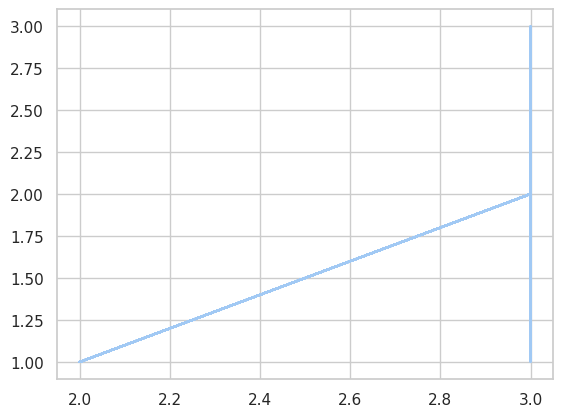

In [136]:
df['bedrooms'] = df['bedrooms'].fillna(df['rooms'] - 1)

<Axes: xlabel='rooms', ylabel='bedrooms'>

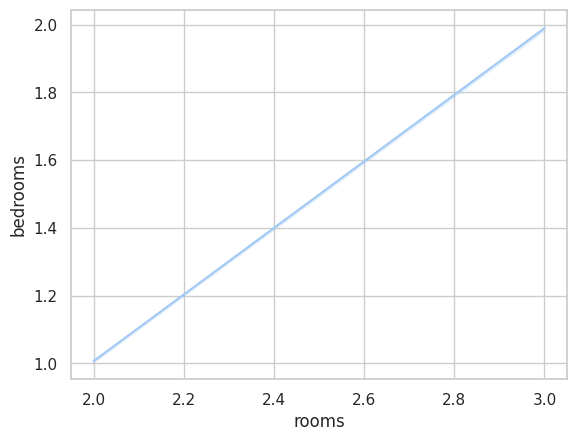

In [143]:
sns.lineplot(x='rooms', y='bedrooms', data=df)

In [131]:
df[df["imputed_ambientes"].isna()]

,ad_type,start_date,end_date,created_on,lat,lon,country,province,city_neighborhood,published_neigborhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,currency,price_period,title,description,property_type,operation_type,Imputed_Neigborhood,imputed_ambientes
id,,,,,,,,,,,,,,,,,,,,,,,


In [47]:
numbers_rooms = list(range(0,100))
# pattern = r"(?:\b|\d+)\s*(?!bedrooms)(?:%s)\s*(?:amb|ambiente|ambientes)\b" % "|".join(number_words.keys())
pattern = r"\b\d{1,2}\s*(?:amb|ambiente|ambientes|dorm|dormitorio|dormitorios)\b"


for i in df["description"].dropna().sample(100):
    print(i)
    nums = re.findall(pattern, i)
    if nums:
        print(nums[0] if len(nums)>0 else np.nan)
        print("\n")

venta departamento excelente 3 ambientes estrenar edificio moderno boedo entrega inmediata < br><br > departamento living comedor salida balcón dormitorio principal placard dormitorio comedor cocina integrada alacenas mesada eléctrico pre-instalación aire acondicionado pisos porcelanato agua caliente central balcón entrega inmediata < br><br > edificio moderno 10 pisos < br><br > barrio boedo av independencia 2 cuadras av jujuy 3 cuadras av belgrano 5 cuadras av san juan < br><br > medios transporte línea subte estación san juan línea subte h estación venezuela línea tren sarmiento estación once)<br><br > < br><br > nota importante información medidas provistas aproximadas deberán ratificarse documentación pertinente compromete contractualmente empresa gastos expensas abl expresados refieren información < br > recabada deberán confirmarse fotografías vinculantes contractuales.<br><br > triada propiedades < br > oficina central 4 788 2600 < br > direccion juramento 1304 caba < br > < br